# Notebook 12 a) Aspect Prediction with Machine Learning Models

This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns using ML models. The output is therefore MULTICLASS.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing
* Section 3 - Run models
* Section 4 - Prediction on validation set

Dataset:
* combinedaspectcheck.xlsx

# Section 1: Import libraries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score,precision_score, recall_score, f1_score
import joblib
import pickle
import warnings

In [3]:
df_accom = pd.read_excel('combinedaspectcheck.xlsx',sheet_name = 'CLEANEDACCOM')
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT")

In [4]:
df_accom.head()

,OrigInd,Category,Cleaned,Noun Phrases,Nouns,Aspect,Sentiment
0,2030,Accommodation,main complaint room made u feel ill,main complaint room,complaint room,Room,-0.2960
1,10751,Accommodation,weekend away staff great room clean shower goo...,great room,room,Room,0.6249
2,11247,Accommodation,great room breakfast fabulous central location,great room breakfast fabulous,room breakfast,Room,0.8176
3,21902,Accommodation,shower great size well toiletry clean towel pr...,clean towel,towel,Room,0.4019
4,22835,Accommodation,great bed breakfast stayed week encore guest h...,lovely clean room facility,room facility,Room,0.7579


# Section 2: Pre-processing

In [5]:
# Drop column
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

In [6]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [7]:
df_accom["Aspect"].value_counts()

Food             350
Hotel            350
Entertainment    350
Staff            350
Room             350
Value            250
Location         220
Name: Aspect, dtype: int64

In [8]:
df_food["Aspect"].value_counts()

Value            350
Menu Choice      350
Food Quality     350
Meal Exp         350
Visit Exp        350
Staff&Service    350
Name: Aspect, dtype: int64

In [9]:
df_attract["Aspect"].value_counts()

Nature           300
Activities       300
Amenities        300
VisitExp&Gen     250
Staff&Service    200
Value            150
History          150
Name: Aspect, dtype: int64

In [10]:
# Function to specify X and y
def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [11]:
# Apply function and print shape
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)


(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


In [12]:
# Train, validation split
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True)
    return X_train,X_val, X_test, y_train,y_val,y_test

In [13]:
# Run function for each category
X_train_accom,X_val_accom,X_test_accom,y_train_accom,y_val_accom,y_test_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,X_test_attract,y_train_attract,y_val_attract,y_test_attract = train_test(X_attract,y_attract)

In [14]:
# Shape of training, validation and test sets for each category
print(X_train_accom.shape, X_val_accom.shape,X_test_accom.shape, y_train_accom.shape, y_val_accom.shape, y_test_accom.shape)
print(X_train_food.shape, X_val_food.shape,X_test_food.shape, y_train_food.shape, y_val_food.shape, y_test_food.shape)
print(X_train_attract.shape, X_val_attract.shape,X_test_attract.shape, y_train_attract.shape, y_val_attract.shape, y_test_attract.shape)

(1776,) (222,) (222,) (1776,) (222,) (222,)
(1680,) (210,) (210,) (1680,) (210,) (210,)
(1320,) (165,) (165,) (1320,) (165,) (165,)


In [15]:
y_train_accom.value_counts()

Food             280
Hotel            280
Entertainment    280
Staff            280
Room             280
Value            200
Location         176
Name: Aspect, dtype: int64

In [16]:
# TFIDF vectorizer function
def vec(X_train, X_val, X_test):
    vect = TfidfVectorizer(use_idf = True, max_df = 1.0, min_df = 1, stop_words = "english", 
                           ngram_range = (1,1),smooth_idf = True, norm = 'l2')
    vect.fit(X_train)
    X_train_tfidf = vect.transform(X_train)
    X_val_tfidf = vect.transform(X_val)
    X_test_tfidf = vect.transform(X_test)
    return vect, X_train_tfidf, X_val_tfidf, X_test_tfidf

In [17]:
# Run function
accom_vect,X_train_accom_tfidf, X_val_accom_tfidf, X_test_accom_tfidf = vec(X_train_accom, X_val_accom,X_test_accom)
food_vect, X_train_food_tfidf, X_val_food_tfidf, X_test_food_tfidf = vec(X_train_food, X_val_food, X_test_food)
attract_vect,X_train_attract_tfidf, X_val_attract_tfidf, X_test_attract_tfidf = vec(X_train_attract, X_val_attract,X_test_attract)

In [18]:
# Function to save tokenizer objects
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [19]:
save_tok('accom_tok.pickle',accom_vect)
save_tok('food_tok.pickle',food_vect)
save_tok('attract_tok.pickle',attract_vect)

In [20]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)
def lab(y_train, y_val, y_test):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.transform(y_val)
    y_test_l = le.transform(y_test)
    return y_train_l, y_val_l, y_test_l

In [21]:
# Apply functions
y_train_accom_l, y_val_accom_l, y_test_accom_l = lab(y_train_accom, y_val_accom, y_test_accom)
y_train_food_l, y_val_food_l, y_test_food_l = lab(y_train_food, y_val_food, y_test_food)
y_train_attract_l, y_val_attract_l, y_test_attract_l = lab(y_train_attract, y_val_attract, y_test_attract)

In [22]:
X_train_accom_tfidf

<1776x795 sparse matrix of type '<class 'numpy.float64'>'
	with 3566 stored elements in Compressed Sparse Row format>

In [23]:
# Stratified K Fold
def strat(model, X_train,y_train,vector):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train,y_train, cv=kfold)
    mean = cv_results.mean()
    df = pd.DataFrame({vector:mean},index = [0])
    return df

# Section 3: Run models

In [36]:
# Define models - balanced as some imbalance in classes
clf1 = MultinomialNB()
clf2 = LogisticRegression(multi_class = 'multinomial', class_weight = "balanced")
clf3 = RandomForestClassifier(class_weight = "balanced")
clf4 = SVC(decision_function_shape='ovr',class_weight = "balanced", probability = True)

In [37]:
# Define models and run cross-validation on the training set data only
ac1 = strat(clf1, X_train_accom_tfidf, y_train_accom_l,"NB")
f1 = strat(clf1, X_train_food_tfidf, y_train_food_l,"NB")
t1 = strat(clf1, X_train_attract_tfidf, y_train_attract_l,"NB")

ac2 = strat(clf2, X_train_accom_tfidf, y_train_accom_l,"LR")
f2 = strat(clf2, X_train_food_tfidf, y_train_food_l,"LR")
t2 = strat(clf2, X_train_attract_tfidf, y_train_attract_l,"LR")

ac3 = strat(clf3, X_train_accom_tfidf, y_train_accom_l,"RF")
f3 = strat(clf3, X_train_food_tfidf, y_train_food_l,"RF")
t3 = strat(clf3, X_train_attract_tfidf, y_train_attract_l,"RF")

ac4 = strat(clf4, X_train_accom_tfidf, y_train_accom_l,"SVM")
f4 = strat(clf4, X_train_food_tfidf, y_train_food_l,"SVM")
t4 = strat(clf4, X_train_attract_tfidf, y_train_attract_l,"SVM")

In [38]:
# Training accuracies all models
models = ["Accom","Food","Attract"]
a = pd.concat([ac1,ac2,ac3,ac4],axis = 1)
b = pd.concat([f1,f2,f3,f4],axis = 1)
c = pd.concat([t1,t2,t3,t4],axis = 1)
all_models = pd.concat([a,b,c],axis = 0)
all_models.set_index([models],inplace = True)
all_models

,NB,LR,RF,SVM
Accom,0.920028,0.918917,0.920618,0.903707
Food,0.923214,0.946429,0.952381,0.938690
Attract,0.803030,0.843939,0.823485,0.816667


# Section 4: Prediction on validation set

In [39]:
# Function to produce predictions and metrics

def prediction(model,X_train,y_train,X_val,y_val,labels):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    target_probs = model.predict_proba(X_val)
    #y_class = np.argmax(y_pred, axis = 0)
    print(classification_report(y_val, y_pred))
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels = labels, yticklabels = labels,cmap = plt.cm.Blues)
    ax.set_ylabel('Actual',labelpad = 10)
    ax.set_xlabel('Predicted', labelpad = 13)
    
    # Test Set Metrics - using macro average as there is label imbalance. ROCAUC also using one versus rest to
    # calculate the average score across classes
    accuracy = accuracy_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val,target_probs, average = "macro", multi_class='ovr')
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    prediction.results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
        
    plt.show()

In [40]:
# Define labels for confusion matrices
labels_accom = ["Entertainment","Food","Hotel","Location","Room","Staff","Value"]
labels_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp"]
labels_attract = ["Activities","Amenities","History","Nature","Staff","Value","VisitGen",]

## Accommodation

### Multinomial NB

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        35
           1       0.94      0.89      0.91        35
           2       0.94      0.91      0.93        35
           3       0.95      0.95      0.95        22
           4       0.89      0.94      0.92        35
           5       0.97      0.94      0.96        35
           6       0.95      0.84      0.89        25

    accuracy                           0.92       222
   macro avg       0.93      0.92      0.92       222
weighted avg       0.92      0.92      0.92       222



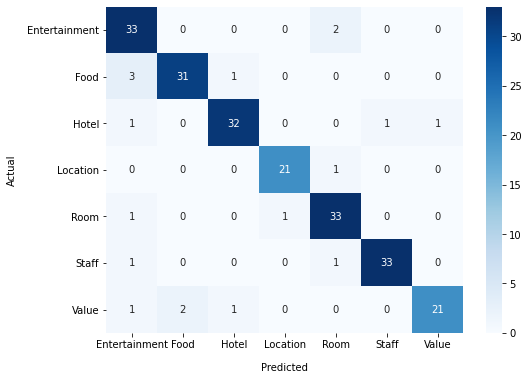

In [41]:
prediction(clf1,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [42]:
modnb1 = prediction.results
modnb1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.918919,0.925306,0.917588,0.920093,0.996666


### Logistic Regression

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        35
           1       1.00      0.94      0.97        35
           2       0.97      0.94      0.96        35
           3       0.96      1.00      0.98        22
           4       0.94      0.94      0.94        35
           5       1.00      0.94      0.97        35
           6       1.00      0.88      0.94        25

    accuracy                           0.95       222
   macro avg       0.96      0.95      0.95       222
weighted avg       0.96      0.95      0.95       222



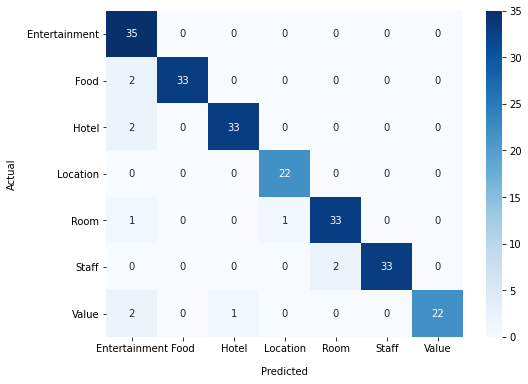

In [43]:
prediction(clf2,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [44]:
modlr1 = prediction.results
modlr1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.95045,0.957614,0.950204,0.951942,0.997002


### Random Forest

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        35
           1       1.00      0.86      0.92        35
           2       0.97      0.91      0.94        35
           3       0.96      1.00      0.98        22
           4       1.00      0.89      0.94        35
           5       1.00      0.97      0.99        35
           6       0.96      0.88      0.92        25

    accuracy                           0.93       222
   macro avg       0.94      0.93      0.93       222
weighted avg       0.94      0.93      0.93       222



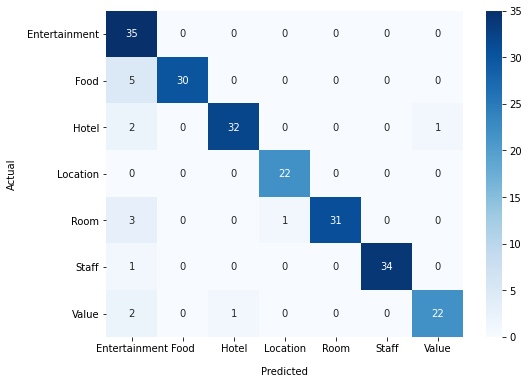

In [45]:
prediction(clf3,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [46]:
modrf1 = prediction.results
modrf1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.927928,0.944558,0.929796,0.932425,0.988832


### SVM

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        35
           1       1.00      0.89      0.94        35
           2       0.97      0.91      0.94        35
           3       0.96      1.00      0.98        22
           4       0.92      0.94      0.93        35
           5       0.97      0.94      0.96        35
           6       0.95      0.84      0.89        25

    accuracy                           0.93       222
   macro avg       0.94      0.93      0.93       222
weighted avg       0.94      0.93      0.93       222



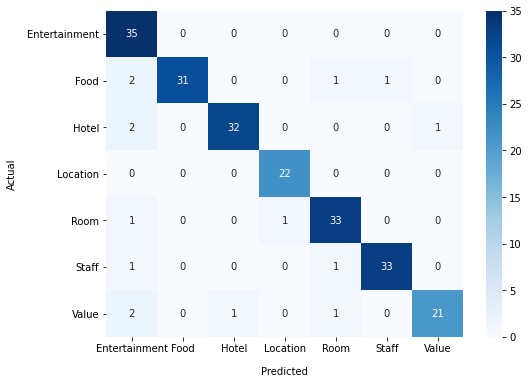

In [47]:
prediction(clf4,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [48]:
modsvm1 = prediction.results
modsvm1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.932432,0.940282,0.932245,0.933643,0.992229


## Food

### Multinomial NB

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.97      0.83      0.89        35
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        35
           4       0.92      0.97      0.94        35
           5       0.94      0.94      0.94        35

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



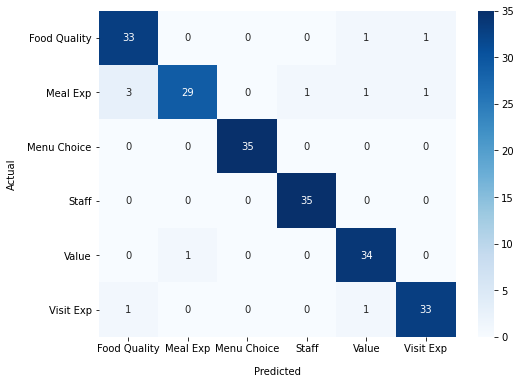

In [49]:
prediction(clf1,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [50]:
modnb2 = prediction.results
modnb2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.947619,0.948759,0.947619,0.947032,0.997769


### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       0.87      0.97      0.92        35
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        35
           4       1.00      0.94      0.97        35
           5       0.94      0.91      0.93        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



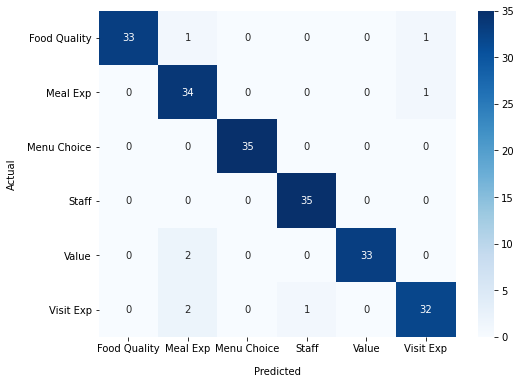

In [51]:
prediction(clf2,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [52]:
modlr2 = prediction.results
modlr2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.961905,0.964199,0.961905,0.962258,0.998667


### Random Forest

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       0.87      0.97      0.92        35
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        35
           4       1.00      0.97      0.99        35
           5       0.94      0.91      0.93        35

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



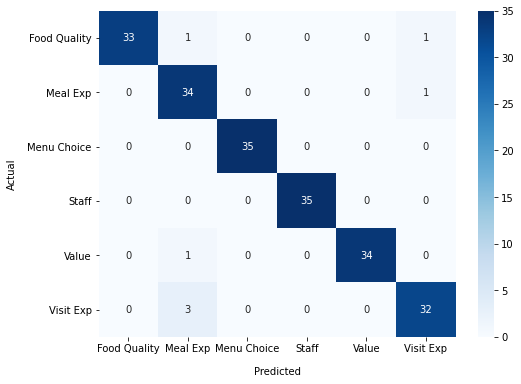

In [53]:
prediction(clf3,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [54]:
modrf2 = prediction.results
modrf2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.966667,0.968829,0.966667,0.967092,0.998354


### SVM

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       0.87      0.97      0.92        35
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        35
           4       1.00      0.97      0.99        35
           5       0.94      0.89      0.91        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



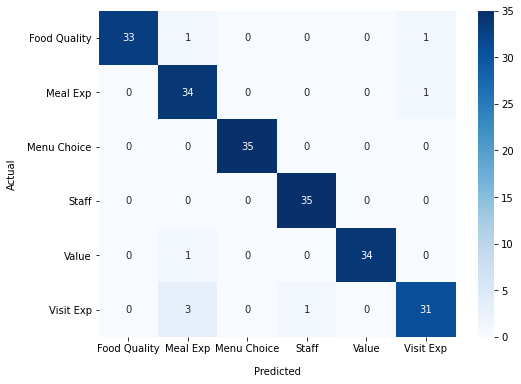

In [55]:
prediction(clf4,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [56]:
modsvm2 = prediction.results
modsvm2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.961905,0.963902,0.961905,0.962116,0.997687


## Attractions

### Multinomial NB

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        30
           1       0.73      0.73      0.73        30
           2       0.90      0.60      0.72        15
           3       0.75      0.90      0.82        30
           4       1.00      0.85      0.92        20
           5       1.00      0.73      0.85        15
           6       0.89      0.68      0.77        25

    accuracy                           0.79       165
   macro avg       0.85      0.77      0.79       165
weighted avg       0.82      0.79      0.79       165



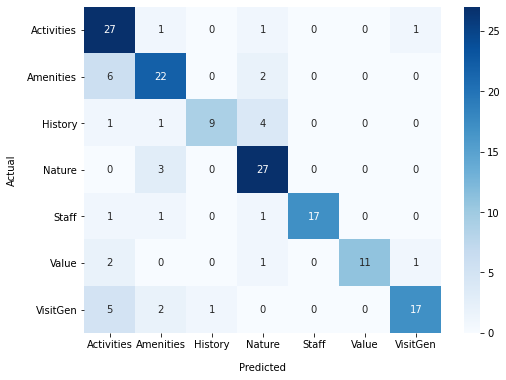

In [57]:
prediction(clf1,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [58]:
modnb3 = prediction.results
modnb3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.787879,0.845847,0.770952,0.794188,0.973551


### Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.87      0.67      0.75        30
           2       0.92      0.80      0.86        15
           3       0.96      0.90      0.93        30
           4       1.00      0.95      0.97        20
           5       0.93      0.93      0.93        15
           6       0.52      0.88      0.66        25

    accuracy                           0.83       165
   macro avg       0.88      0.84      0.85       165
weighted avg       0.87      0.83      0.84       165



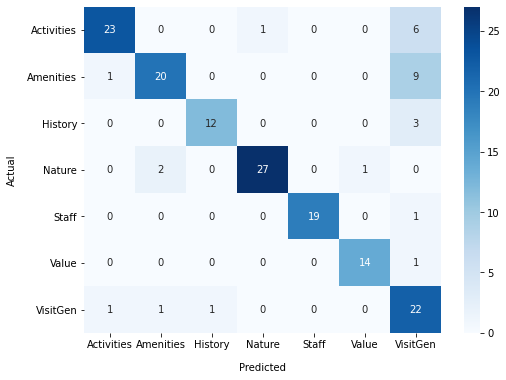

In [59]:
prediction(clf2,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [60]:
clf2.fit(X_train_attract_tfidf,y_train_attract_l)
filename = 'best_model_attract.sav'
joblib.dump(clf2, filename)

['best_model_attract.sav']

In [61]:
modlr3 = prediction.results
modlr3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.830303,0.876296,0.842381,0.849095,0.974893


### Random Forest

              precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.77      0.67      0.71        30
           2       0.91      0.67      0.77        15
           3       0.96      0.87      0.91        30
           4       1.00      0.90      0.95        20
           5       1.00      1.00      1.00        15
           6       0.51      0.88      0.65        25

    accuracy                           0.81       165
   macro avg       0.87      0.82      0.83       165
weighted avg       0.85      0.81      0.82       165



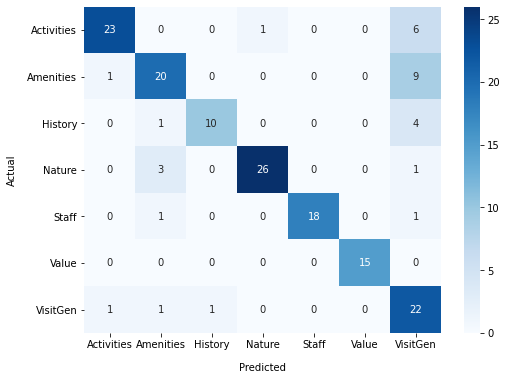

In [62]:
prediction(clf3,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [63]:
modrf3 = prediction.results
modrf3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.812121,0.867559,0.820952,0.83237,0.947937


### SVM

              precision    recall  f1-score   support

           0       0.88      0.73      0.80        30
           1       0.86      0.63      0.73        30
           2       0.92      0.73      0.81        15
           3       0.96      0.87      0.91        30
           4       1.00      0.90      0.95        20
           5       0.93      0.93      0.93        15
           6       0.48      0.88      0.62        25

    accuracy                           0.80       165
   macro avg       0.86      0.81      0.82       165
weighted avg       0.85      0.80      0.81       165



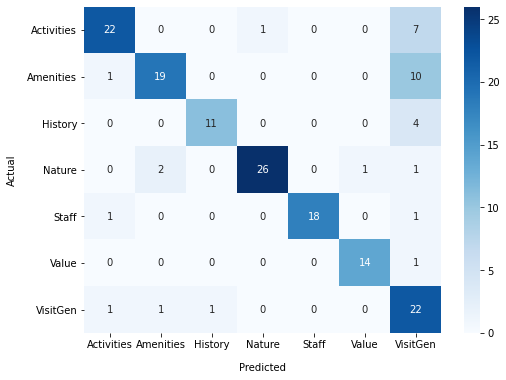

In [64]:
prediction(clf4,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [65]:
modsvm3 = prediction.results
modsvm3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.8,0.862123,0.811429,0.822612,0.964855


# Section 5: Summary Tables

In [66]:
accom = pd.concat([modnb1,modlr1,modrf1,modsvm1])
accom.index = ["Accom NB","Accom LR","Accom RF","Accom SVM"]
accom.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Accom LR,0.950450,0.957614,0.950204,0.951942,0.997002
Accom NB,0.918919,0.925306,0.917588,0.920093,0.996666
Accom SVM,0.932432,0.940282,0.932245,0.933643,0.992229
Accom RF,0.927928,0.944558,0.929796,0.932425,0.988832


In [67]:
food = pd.concat([modnb2,modlr2,modrf2,modsvm2])
food.index = ["Food NB","Food LR","Food RF","Food SVM"]
food.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food LR,0.961905,0.964199,0.961905,0.962258,0.998667
Food RF,0.966667,0.968829,0.966667,0.967092,0.998354
Food NB,0.947619,0.948759,0.947619,0.947032,0.997769
Food SVM,0.961905,0.963902,0.961905,0.962116,0.997687


In [68]:
attract = pd.concat([modnb3,modlr3,modrf3,modsvm3])
attract.index = ["Attract NB","Attract LR","Attract RF","Attract SVM"]
attract.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Attract LR,0.830303,0.876296,0.842381,0.849095,0.974893
Attract NB,0.787879,0.845847,0.770952,0.794188,0.973551
Attract SVM,0.800000,0.862123,0.811429,0.822612,0.964855
Attract RF,0.812121,0.867559,0.820952,0.832370,0.947937


# Section 6: Hyperparameter Tuning 

In [69]:
warnings.filterwarnings('ignore') 

In [70]:
best_model = LogisticRegression(class_weight = "balanced")
best_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [71]:
parameters = {'C': [0.001,0.01,0.1,1,10,100], 'penalty': ['none', 'l1', 'l2', 'elasticnet'],'solver': ['newton-cg', 'lbfgs', 'sag','saga']}
clf = GridSearchCV(best_model,param_grid=parameters, cv = 10, scoring = 'roc_auc_ovr_weighted')

Note liblinear not supported with multinomial loss in multi-class problems

### Accommodation

In [72]:
clf.fit(X_train_accom_tfidf,y_train_accom)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovr_weighted')

In [73]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.9961835395473045
Best estimator: LogisticRegression(C=10, class_weight='balanced', solver='saga')




In [74]:
# Set up the best model
best_model_accom = LogisticRegression(class_weight = "balanced",C=10, penalty = 'l2', solver = 'saga')

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        35
           1       1.00      0.91      0.96        35
           2       0.97      0.91      0.94        35
           3       0.96      1.00      0.98        22
           4       0.97      0.94      0.96        35
           5       0.97      0.97      0.97        35
           6       0.96      0.88      0.92        25

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222



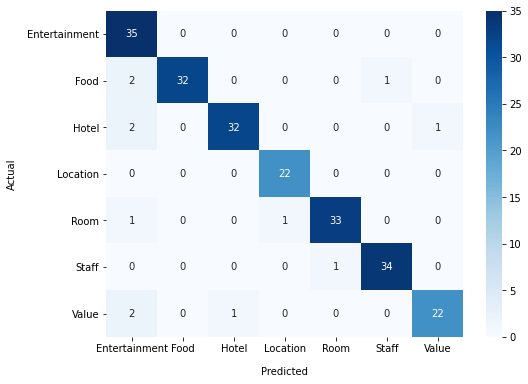

In [75]:
prediction(best_model_accom,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [76]:
modlrah = prediction.results
modlrah.index = ["Accommodation"]
modlrah

,Accuracy,Precision,Recall,F1,ROCAUC
Accommodation,0.945946,0.951156,0.946122,0.946841,0.997657


In [77]:
# Save out for combined model
best_model_accom.fit(X_train_accom_tfidf,y_train_accom_l)
filename = 'best_model_accom.sav'
joblib.dump(best_model_accom, filename)

['best_model_accom.sav']

### Food

In [78]:
clf.fit(X_train_food_tfidf, y_train_food)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovr_weighted')

In [79]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.9969897959183672
Best estimator: LogisticRegression(C=1, class_weight='balanced', solver='newton-cg')




In [82]:
# Set up the best model
best_model_food = LogisticRegression(multi_class = 'multinomial', class_weight = "balanced",C=10, penalty = 'l2', solver = 'newton-cg')

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.89      0.94      0.92        35
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        35
           4       1.00      0.94      0.97        35
           5       0.94      0.94      0.94        35

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



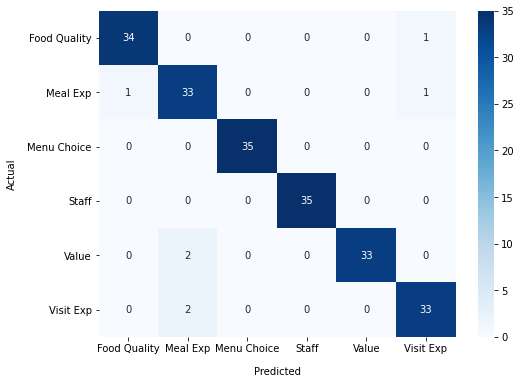

In [83]:
prediction(best_model_food,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [84]:
modlrfh = prediction.results
modlrfh.index = ["Food"]
modlrfh

,Accuracy,Precision,Recall,F1,ROCAUC
Food,0.966667,0.967696,0.966667,0.966923,0.998585


### Attractions

In [85]:
clf.fit(X_train_attract_tfidf, y_train_attract)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovr_weighted')

In [86]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.9781064873557689
Best estimator: LogisticRegression(C=10, class_weight='balanced')




In [87]:
# Set up the best model
best_model_attract = LogisticRegression(multi_class = 'multinomial', class_weight = "balanced",C=10, penalty = 'l2', solver = 'lbfgs')

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        30
           1       0.83      0.67      0.74        30
           2       0.92      0.80      0.86        15
           3       0.96      0.87      0.91        30
           4       1.00      0.90      0.95        20
           5       0.93      0.93      0.93        15
           6       0.52      0.88      0.66        25

    accuracy                           0.82       165
   macro avg       0.87      0.83      0.84       165
weighted avg       0.86      0.82      0.83       165



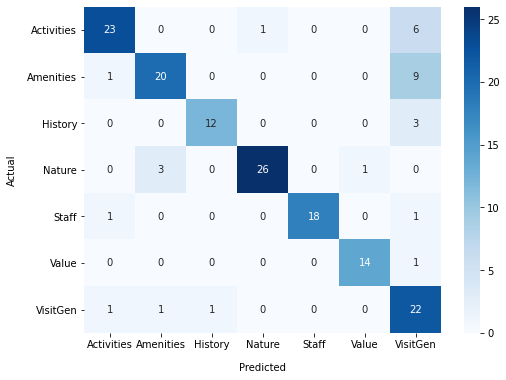

In [88]:
prediction(best_model_attract,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [89]:
modlath = prediction.results
modlath.index = ["Attractions"]
modlath

,Accuracy,Precision,Recall,F1,ROCAUC
Attractions,0.818182,0.865876,0.830476,0.83843,0.970916


In [90]:
hyp = pd.concat([modlrah, modlrfh, modlath])
hyp.index = ["Accom Hyp","Food Hyp","Attract Hyp"]
hyp

,Accuracy,Precision,Recall,F1,ROCAUC
Accom Hyp,0.945946,0.951156,0.946122,0.946841,0.997657
Food Hyp,0.966667,0.967696,0.966667,0.966923,0.998585
Attract Hyp,0.818182,0.865876,0.830476,0.838430,0.970916


# Section 7: Best Model Against Test Set

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        35
           1       0.97      0.97      0.97        35
           2       1.00      1.00      1.00        35
           3       0.95      0.95      0.95        22
           4       0.97      0.89      0.93        35
           5       0.92      0.94      0.93        35
           6       1.00      0.88      0.94        25

    accuracy                           0.95       222
   macro avg       0.95      0.94      0.95       222
weighted avg       0.95      0.95      0.95       222



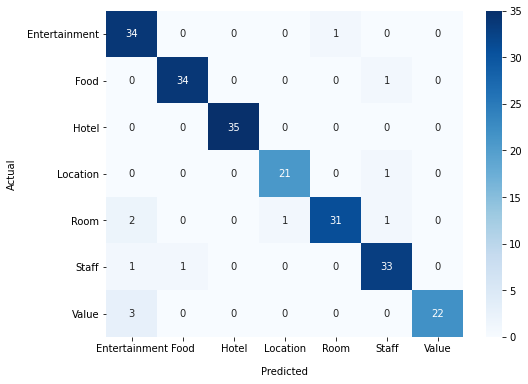

In [91]:
# Hyperparameter tuned model is best model for accommodation
prediction(best_model_accom,X_train_accom_tfidf,y_train_accom_l,X_test_accom_tfidf,y_test_accom_l,labels_accom)

In [92]:
modtestaccom = prediction.results
modtestaccom.index = ["Accommodation"]
modtestaccom

,Accuracy,Precision,Recall,F1,ROCAUC
Accommodation,0.945946,0.951627,0.943711,0.946252,0.997628


              precision    recall  f1-score   support

           0       0.90      1.00      0.95        35
           1       0.89      0.94      0.92        35
           2       1.00      0.97      0.99        35
           3       1.00      1.00      1.00        35
           4       0.97      0.97      0.97        35
           5       1.00      0.86      0.92        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



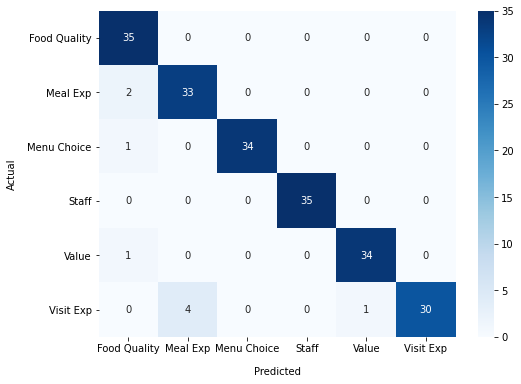

In [93]:
prediction(best_model_food,X_train_food_tfidf,y_train_food_l,X_test_food_tfidf,y_test_food_l,labels_food)

In [94]:
modtestfood = prediction.results
modtestfood.index = ["Food"]
modtestfood

,Accuracy,Precision,Recall,F1,ROCAUC
Food,0.957143,0.960126,0.957143,0.957104,0.996517


              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.93      0.93      0.93        30
           2       1.00      1.00      1.00        15
           3       0.93      0.87      0.90        30
           4       0.80      0.80      0.80        20
           5       1.00      1.00      1.00        15
           6       0.70      0.84      0.76        25

    accuracy                           0.89       165
   macro avg       0.90      0.90      0.90       165
weighted avg       0.90      0.89      0.89       165



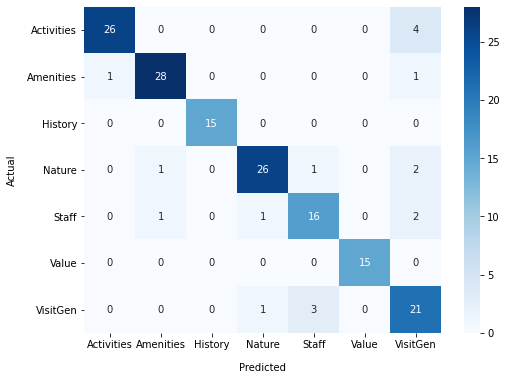

In [95]:
prediction(best_model_attract,X_train_attract_tfidf,y_train_attract_l,X_test_attract_tfidf,y_test_attract_l,labels_attract)

In [96]:
modtestattract = prediction.results
modtestattract.index = ["Attract"]
modtestattract

,Accuracy,Precision,Recall,F1,ROCAUC
Attract,0.890909,0.903553,0.900952,0.900829,0.986359


In [98]:
test = pd.concat([modtestaccom, modtestfood,modtestattract])
test.index = ["Accom Test","Food Test","Attract Test"]
test

,Accuracy,Precision,Recall,F1,ROCAUC
Accom Test,0.945946,0.951627,0.943711,0.946252,0.997628
Food Test,0.957143,0.960126,0.957143,0.957104,0.996517
Attract Test,0.890909,0.903553,0.900952,0.900829,0.986359


Excluding the food model:

In [99]:
test = pd.concat([modtestaccom, modtestattract])
test.index = ["Accom Test","Attract Test"]
test

,Accuracy,Precision,Recall,F1,ROCAUC
Accom Test,0.945946,0.951627,0.943711,0.946252,0.997628
Attract Test,0.890909,0.903553,0.900952,0.900829,0.986359
